# ✅Fiber Section Visualization

In [1]:
import numpy as np
import openseespy.opensees as ops
import opstool as opst

## OpenSeesPy Model Creation

Here we create a pier example.

In [2]:
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)

def create_pier(sec_tag):  
    ops.node(1, 0.0, 0.0, 0.0)
    ops.node(2, 0.0, 0.0, 6.0)
    ops.mass(2, 50, 50, 50, 0.0, 0.0, 0.0)
    ops.fix(1, 1, 1, 1, 1, 1, 1)
    ops.geomTransf('Linear', 1, *[-1.0, 0.0, 0.0])
    ops.beamIntegration('Lobatto', 1, sec_tag, 6)
    ops.element('forceBeamColumn', 1, *[1, 2], 1, 1)

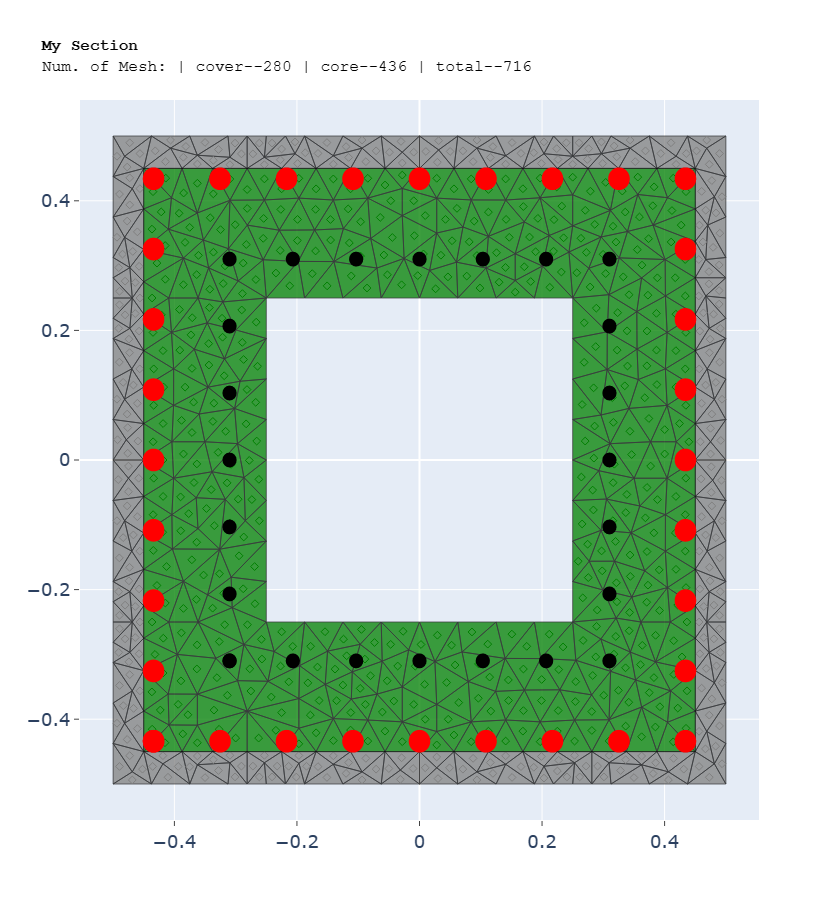

In [3]:
outlines = [[0, 0], [1, 0], [1, 1], [0, 1]]
coverlines = opst.offset(outlines, d=0.05)
cover = opst.add_polygon(outlines, holes=[coverlines])
holelines = [[0.25, 0.25], [0.75, 0.25], [0.75, 0.75], [0.25, 0.75]]
core = opst.add_polygon(coverlines, holes=[holelines])
# ------------------------------------------------------------
sec = opst.SecMesh()
sec.assign_group(dict(cover=cover, core=core))
sec.assign_mesh_size(dict(cover=0.05, core=0.1))
sec.assign_group_color(dict(cover="gray", core="green"))
# Specify the material tag in the opensees, the material needs to be defined by you beforehand.
ops.uniaxialMaterial('Concrete01', 1, -25.E3, -0.002, -10.E3, -0.005)
ops.uniaxialMaterial('Concrete01', 2, -40.E3, -0.006, -30.E3, -0.015)
sec.assign_ops_matTag(dict(cover=1, core=2))
sec.mesh()
# ------------------------------------------------------------
# add rebars
ops.uniaxialMaterial('Steel01', 3, 200.E3, 2.E8, 0.02)
rebars = opst.Rebars()
rebar_lines1 = opst.offset(outlines, d=0.05 + 0.032 / 2)
rebars.add_rebar_line(
    points=rebar_lines1, dia=0.032, gap=0.1, color="red", matTag=3
)
rebar_lines2 = opst.offset(holelines, d=-(0.05 + 0.02 / 2))
rebars.add_rebar_line(
    points=rebar_lines2, dia=0.020, gap=0.1, color="black", matTag=3
)
# add to the sec
sec.add_rebars(rebars)
# -----------------------------------------------------------------------------
sec.centring()
sec.view(fill=True, engine='plotly', save_html=None, on_notebook=True)

In [4]:
sec_props = sec.get_frame_props(display_results=True)
G = 3.45E7 / (2 * (1 + 0.2))
J = sec_props['J']  # or other number if you don't care
sec.opspy_cmds(secTag=1, GJ=G * J)   # generate openseespy fiber commands

                           Frame Section Properties                            
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Symbol    ┃ Value                  ┃ Definition                             ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ A         │ 7.500E-01              │ Cross-sectional area                   │
│ centroid  │ (5.000E-01, 5.000E-01) │ Elastic centroid                       │
│ Iy        │ 7.812E-02              │ Moment of inertia y-axis               │
│ Iz        │ 7.813E-02              │ Moment of inertia z-axis               │
│ Iyz       │ 8.327E-17              │ Product of inertia                     │
│ Wyt       │ 5.413E+13              │ Section moduli of top fibres y-axis    │
│ Wyb       │ 7.812E-02              │ Section moduli of bottom fibres y-axis │
│ Wzt       │ 8.279E+13              │ Section moduli of top fibres z-axis    │
│ Wzb       │ 7.813E-02              │ Section moduli of bottom fibres z-axis │
│ J         │ -2.458E-01             │ Torsion constant                       │
│ phi       │ 0.000E+00              │ Principal axis angle                   │
│ mass      │ 7.500E-01              │ Section mass                           │
│ rho_rebar │ 4.586E-02              │ Ratio of reinforcement                 │
└───────────┴────────────────────────┴────────────────────────────────────────┘

In [5]:
create_pier(sec_tag=1)

## Visualization of fiber section geometry information

In [6]:
ele_sec = []
for i in range(6):
    ele_sec.append((1, i+1))

FEMdata = opst.GetFEMdata()
FEMdata.get_fiber_data(ele_sec=ele_sec, save_file='FiberData.hdf5')

Fiber section data saved in opstool_output/FiberData.hdf5 !

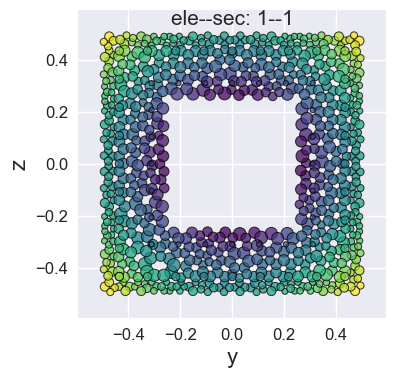

In [7]:
opst.plot_fiber_sec(ele_sec=[(1,1)],
                   results_dir="opstool_output",
                   input_file='FiberData.hdf5')

Of course, you can also use a custom color ``dict``, where the keys are the **OpenSeesPy material tags** in the cross section and the values are any ``matplotlib`` supported color labels.

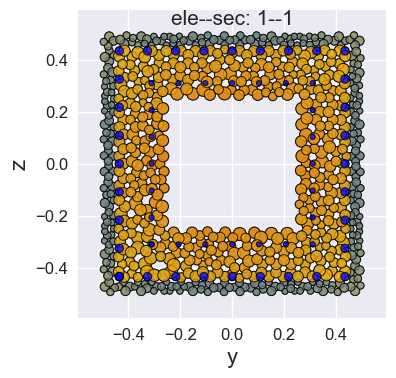

In [8]:
opst.plot_fiber_sec(ele_sec=[(1,1)],
                   results_dir="opstool_output",
                   input_file='FiberData.hdf5',
                   mat_color={1: 'gray', 2: 'orange', 3: 'blue'})

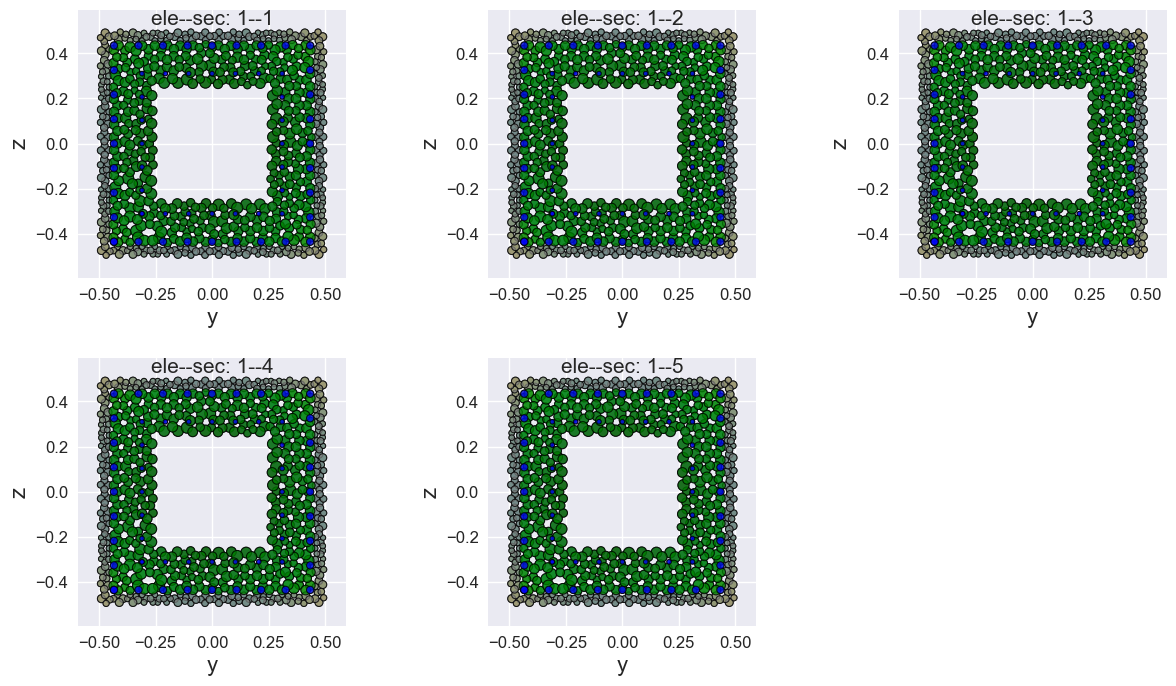

In [9]:
opst.plot_fiber_sec(ele_sec=ele_sec[:-1],
                   results_dir="opstool_output",
                   input_file='FiberData.hdf5',
                   mat_color={1: 'gray', 2: 'green', 3: 'blue'})

## Fiber section responses visualization

applying the dynamic load

In [10]:
# --------------------------------------------------
# dynamic load
ops.rayleigh(0.0, 0.0, 0.0, 0.000625)
ops.loadConst('-time', 0.0)

# applying Dynamic Ground motion analysis
dt = 0.02
ttot = 5
npts = int(ttot / dt)
x = np.linspace(0, ttot, npts)
data = 2.0 * np.sin(2 * np.pi * x)
ops.timeSeries('Path', 2, '-dt', dt, '-values', *data, '-factor', 9.81)
ops.pattern('UniformExcitation', 2, 1, '-accel', 2)
ops.pattern('UniformExcitation', 3, 2, '-accel', 2)

ops.wipeAnalysis()
ops.system('BandGeneral')
# Create the constraint handler, the transformation method
ops.constraints('Transformation')
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer('RCM')
ops.test('NormDispIncr', 1e-8, 10)
ops.algorithm('Linear')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')

In [11]:
for i in range(npts):
    ops.analyze(1, dt)
    FEMdata.get_resp_step()
# save all responses data after loop
FEMdata.save_resp_all(save_file="RespStepData-1.hdf5")

Model data saved in opstool_output/ModelData.hdf5!

All responses data saved in opstool_output/RespStepData-1.hdf5 !

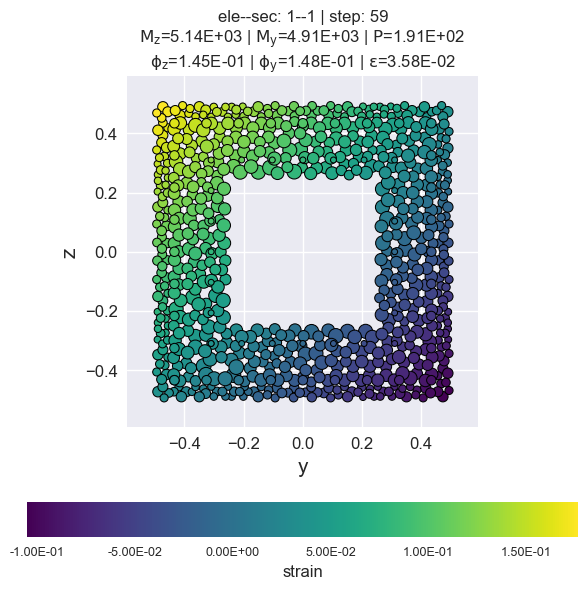

In [12]:
secvis = opst.FiberSecVis(input_file="RespStepData-1.hdf5", opacity=1, colormap='viridis')
secvis.resp_vis(ele_tag=1, sec_tag=1,
                step=None,
                show_variable='strain',
                show_mats=[1, 2, 3],)

stress of rebars by matTag 3

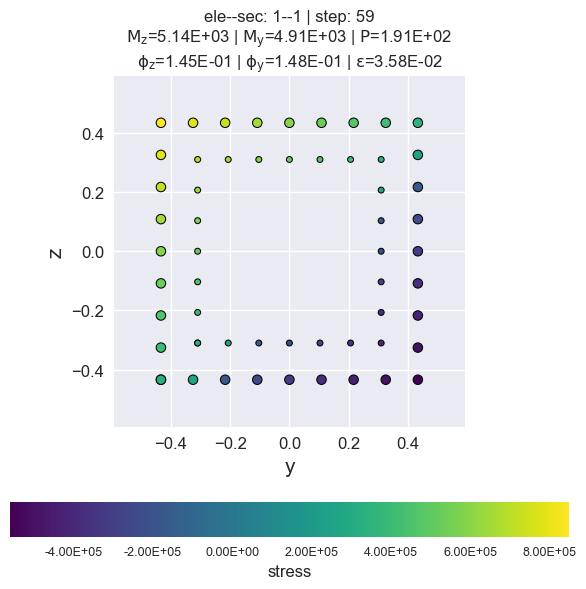

In [13]:
secvis.resp_vis(ele_tag=1, sec_tag=1,
                step=None,
                show_variable='stress',
                show_mats=[3],)

Generate animated gif files.

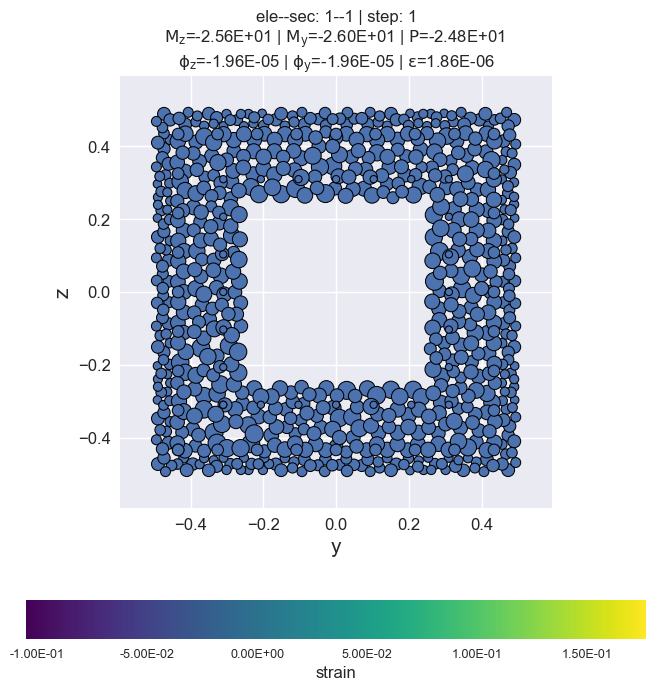

MovieWriter ffmpeg unavailable; using Pillow instead.


In [14]:
secvis.animation(ele_tag=1, sec_tag=1,
                 output_file='images/sec1-1.gif',
                 show_variable='strain',
                 show_mats=[1, 2, 3],
                 framerate=10)

## plot forces-deformations relationship

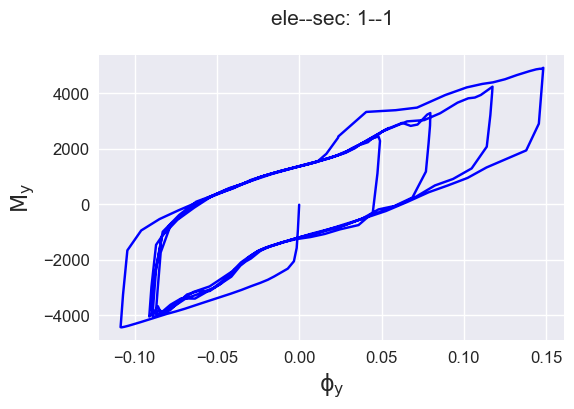

In [15]:
defos, forces = secvis.force_defo_vis(ele_tag=1, sec_tag=1,
                                      force_type="My",
                                      defo_type="Phiy")